In [ ]:
# Core Imports
import json
import logging
import sys
from pathlib import Path

import cv2
import motmetrics as mm
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

try:
    from sort import Sort, iou_batch
except ImportError:
    print("[ERROR] sort.py not found. Please ensure it is in the same directory as this notebook.")
    # Exit gracefully if sort isn't available
    if 'ipykernel' in sys.modules:
        from IPython import get_ipython
        get_ipython().kernel.do_shutdown(True)
    else:
        sys.exit(1)

# Logging Configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logging.info("Logger initialized.")


# Model Paths
YOLO_L3_PATH = Path("models/yolov11_baseline.pt")
AUX_HEADS_PATH = Path("models/hierarchical_heads.pt")
MANIFEST_PATH = Path("manifest.json")

# Data Paths
VISDRONE_SEQUENCES_DIR = Path("VisDrone2019-MOT-train/sequences")
MOT_GT_DIR = Path("converted_visdrone_miotcd_train/mot_labels")

# Output Paths
MOT_RESULTS_DIR = Path("mot_evaluation_results_train/raw_predictions")
METRICS_OUTPUT_DIR = Path("mot_evaluation_results_train/metrics")
MOT_RESULTS_DIR.mkdir(exist_ok=True, parents=True)
METRICS_OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Device Configuration
USE_GPU = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if USE_GPU else "cpu")
logging.info(f"Using device: {DEVICE}")

# Hierarchical Model Hyperparameters (Tune these to adjust performance)
BASELINE_CONF_THRESH = 0.50
L3_CONFIRM_THRESH = 0.50
L3_CANDIDATE_THRESH = 0.05  # Low threshold to generate candidates for rescue
L2_RESCUE_THRESH = 0.55
L1_RESCUE_THRESH = 0.50

# SORT Tracker Hyperparameters
SORT_MAX_AGE = 5      # Increased max_age for better handling of temporary occlusions
SORT_MIN_HITS = 3     # Number of consecutive frames an object must be seen to start a track
SORT_IOU_THRESH = 0.3 # IoU threshold for associating detections to existing tracks

# Load Class Definitions from Manifest
try:
    with open(MANIFEST_PATH) as f:
        manifest = json.load(f)
    hierarchy = manifest['hierarchy']
    L3_NAMES = hierarchy['L3_NAMES']
    L2_NAMES = hierarchy['L2_NAMES']
    CLASS_TO_L2 = hierarchy['CLASS_TO_L2']
    # Create reverse mapping for convenience
    L3_NAME_TO_IDX = {name: i for i, name in enumerate(L3_NAMES)}
    logging.info(f"Loaded class manifest. Found {len(L3_NAMES)} L3 classes.")
except FileNotFoundError:
    logging.error(f"FATAL: Manifest file not found at {MANIFEST_PATH}. Cannot proceed.")
    # Stop execution if the manifest is missing
    if 'ipykernel' in sys.modules: from IPython import get_ipython; get_ipython().kernel.do_shutdown(True)
    else: sys.exit(1)

2025-09-05 23:23:58 [INFO] - Logger initialized.
2025-09-05 23:23:58 [INFO] - Using device: cuda:0
2025-09-05 23:23:58 [INFO] - Loaded class manifest. Found 8 L3 classes.


In [ ]:
import torch.nn as nn
from ultralytics import YOLO
from typing import Dict, Tuple, List

# PyTorch Model Definitions (Copied from Inference Notebook for self-containment)
class FeatureCompressor(nn.Module):
    def __init__(self, in_channels: int, out_dim: int, hidden_dim_factor: int = 2):
        super().__init__()
        hidden_dim = out_dim * hidden_dim_factor
        self.trunk = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(hidden_dim), nn.SiLU(inplace=True),
            nn.Conv2d(hidden_dim, out_dim, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(out_dim), nn.SiLU(inplace=True),
        ); self.pool = nn.AdaptiveAvgPool2d((1, 1))
    def forward(self, x: torch.Tensor) -> torch.Tensor: return torch.flatten(self.pool(self.trunk(x)), 1)

class AuxHeadsMLP(nn.Module):
    def __init__(self, in_dim: int, num_l2_classes: int, hidden_dim: int = 512, neck_dim: int = 128, dropout: float = 0.3):
        super().__init__(); self.trunk = nn.Sequential(nn.Linear(in_dim, hidden_dim), nn.LayerNorm(hidden_dim), nn.SiLU(inplace=True), nn.Dropout(dropout), nn.Linear(hidden_dim, hidden_dim // 2), nn.LayerNorm(hidden_dim // 2), nn.SiLU(inplace=True), nn.Dropout(dropout)); self.l2_neck = nn.Sequential(nn.Linear(hidden_dim // 2, neck_dim), nn.LayerNorm(neck_dim), nn.SiLU(inplace=True)); self.l1_neck = nn.Sequential(nn.Linear(hidden_dim // 2, neck_dim), nn.LayerNorm(neck_dim), nn.SiLU(inplace=True)); self.l2_head = nn.Linear(neck_dim, num_l2_classes); self.l1_head = nn.Linear(neck_dim, 1)
    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        shared_features = self.trunk(x); l2_features = self.l2_neck(shared_features); l1_features = self.l1_neck(shared_features); return {"l1_logits": self.l1_head(l1_features), "l2_logits": self.l2_head(l2_features)}

class HierarchicalDetector:
    def __init__(self, yolo_path: Path, aux_heads_path: Path, manifest_path: Path):
        self.device = DEVICE
        with open(manifest_path) as f: self.manifest = json.load(f)
        self.hierarchy = self.manifest['hierarchy']; self.l3_names = self.hierarchy['L3_NAMES']; self.l2_names = self.hierarchy['L2_NAMES']; self.class_to_l2 = self.hierarchy['CLASS_TO_L2']
        feat_config = self.manifest['feature_extraction']; self.compressed_dim = feat_config['compressed_dim']; self.roi_align_size = tuple(feat_config['roi_align_size']); self.pyramid_thresholds = tuple(feat_config['pyramid_thresholds'])
        self.yolo_model = YOLO(yolo_path); self.feature_maps = {}; self._attach_hooks()
        self._instantiate_aux_models()
        checkpoint = torch.load(aux_heads_path, map_location=self.device)
        self.aux_heads_mlp.load_state_dict(checkpoint['model_state_dict']); self.aux_heads_mlp.eval(); self.feature_compressors.eval()
        logging.info("HierarchicalDetector initialized and ready.")

    def _attach_hooks(self):
        def get_features_hook(name):
            def hook(model, input, output): self.feature_maps[name] = output[0] if isinstance(output, tuple) else output
            return hook
        try:
            p5_module_idx, p4_module_idx, p3_module_idx = 16, 19, 22
            self.hook_p5 = self.yolo_model.model.model[p5_module_idx].register_forward_hook(get_features_hook('p5')); self.hook_p4 = self.yolo_model.model.model[p4_module_idx].register_forward_hook(get_features_hook('p4')); self.hook_p3 = self.yolo_model.model.model[p3_module_idx].register_forward_hook(get_features_hook('p3'))
            self.yolo_model.predict(torch.zeros(1, 3, 640, 640).to(self.device), verbose=False) # Dummy pass
            self.strides = {'p3': self.yolo_model.model.stride[0], 'p4': self.yolo_model.model.stride[1], 'p5': self.yolo_model.model.stride[2]}
        except Exception as e: logging.error(f"Hook attachment failed: {e}"); raise e

    def _instantiate_aux_models(self):
        self.yolo_model.predict(torch.zeros(1, 3, 640, 640).to(self.device), verbose=False)
        p3_channels, p4_channels, p5_channels = self.feature_maps['p3'].shape[1], self.feature_maps['p4'].shape[1], self.feature_maps['p5'].shape[1]
        self.feature_compressors = nn.ModuleDict({'p3': FeatureCompressor(p3_channels, self.compressed_dim), 'p4': FeatureCompressor(p4_channels, self.compressed_dim), 'p5': FeatureCompressor(p5_channels, self.compressed_dim)}).to(self.device)
        self.aux_heads_mlp = AuxHeadsMLP(self.compressed_dim, len(self.l2_names)).to(self.device)

    def _extract_compact_features(self, candidate_boxes: torch.Tensor) -> torch.Tensor:
        from torchvision.ops import roi_align
        def choose_pyramid_level(boxes_xyxy: torch.Tensor, thresholds: Tuple[float, float]):
            if boxes_xyxy.numel() == 0: return torch.empty(0, dtype=torch.long, device=boxes_xyxy.device)
            max_side = torch.maximum(boxes_xyxy[:, 2] - boxes_xyxy[:, 0], boxes_xyxy[:, 3] - boxes_xyxy[:, 1])
            levels = torch.full_like(max_side, 4, dtype=torch.long); levels[max_side <= thresholds[0]] = 3; levels[max_side > thresholds[1]] = 5
            return levels
        levels = choose_pyramid_level(candidate_boxes, self.pyramid_thresholds); final_features = torch.zeros(len(candidate_boxes), self.compressed_dim, device=self.device)
        for level_idx in [3, 4, 5]:
            mask = (levels == level_idx)
            if not mask.any(): continue
            level_name = f'p{level_idx}'; boxes_on_level = candidate_boxes[mask]
            pooled_feats = roi_align(self.feature_maps[level_name], [boxes_on_level], output_size=self.roi_align_size, spatial_scale=1.0 / self.strides[level_name])
            if pooled_feats.numel() > 0: final_features[mask] = self.feature_compressors[level_name](pooled_feats)
        return final_features

    @torch.no_grad()
    def predict(self, image_path: str, l3_confirm_thresh: float, l3_candidate_thresh: float, l2_rescue_thresh: float, l1_rescue_thresh: float):
        results = self.yolo_model(image_path, conf=l3_candidate_thresh, device=self.device, verbose=False)
        result = results[0]
        if result.boxes is None or len(result.boxes) == 0:
            # Return empty lists for all outputs for consistency
            return [], [], result

        candidates = result.boxes
        candidate_boxes = candidates.xyxy
        compact_features = self._extract_compact_features(candidate_boxes)
        aux_outputs = self.aux_heads_mlp(compact_features)
        l1_probs = torch.sigmoid(aux_outputs['l1_logits']).squeeze(-1)
        l2_probs_all = torch.softmax(aux_outputs['l2_logits'], dim=1)
        l2_probs, l2_indices = torch.max(l2_probs_all, dim=1)

        # track both successful and rejected candidates
        final_detections = []
        rejected_candidates = [] # New list to store rejected candidates

        for i in range(len(candidates)):
            l3_conf, l3_cls_idx = candidates.conf[i].item(), candidates.cls[i].int().item()
            l3_cls_name = self.l3_names[l3_cls_idx]
            base_det = {'bbox': candidates.xyxy[i].cpu().numpy(), 'l3_label': l3_cls_name, 'l3_conf': l3_conf}

            if l3_conf >= l3_confirm_thresh:
                final_detections.append({**base_det, 'type': 'confirmed'})
                continue

            # This candidate is in the "rescue zone"
            l1_prob, l2_prob, l2_idx = l1_probs[i].item(), l2_probs[i].item(), l2_indices[i].item()
            l2_name = self.l2_names[l2_idx]
            is_consistent = self.class_to_l2.get(l3_cls_name) == l2_name

            if l2_prob >= l2_rescue_thresh and is_consistent:
                final_detections.append({**base_det, 'type': 'rescued_l2', 'l2_label': l2_name, 'l2_conf': l2_prob})
            elif l1_prob >= l1_rescue_thresh:
                final_detections.append({**base_det, 'type': 'rescued_l1', 'l1_conf': l1_prob})
            else:
                # If it fails all rescue checks, log it as rejected
                rejected_candidates.append({**base_det, 'type': 'rejected'})
        
        return final_detections, rejected_candidates, result

# --- Ground Truth & Coordinate Utilities ---
def load_mot_gt_file(gt_path: Path) -> np.ndarray:
    """Loads a MOT ground truth file. Format: [class_id, target_id, xc, yc, wn, hn]"""
    if not gt_path.exists(): return np.empty((0, 6), dtype=np.float32)
    try:
        data = np.loadtxt(str(gt_path), dtype=np.float32, delimiter=' ')
        return data.reshape(1, -1) if data.ndim == 1 else data
    except Exception as e:
        logging.warning(f"Could not parse GT file {gt_path}. Error: {e}")
        return np.empty((0, 6), dtype=np.float32)

def yolo_to_xyxy(boxes_yolo: np.ndarray, img_shape: Tuple[int, int]) -> np.ndarray:
    """Converts normalized YOLO format [xc, yc, w, h] to absolute [x1, y1, x2, y2]."""
    if boxes_yolo.size == 0: return np.empty((0, 4), dtype=np.float32)
    img_h, img_w = img_shape
    xc, yc, w, h = boxes_yolo[:, 0], boxes_yolo[:, 1], boxes_yolo[:, 2], boxes_yolo[:, 3]
    x1 = (xc - w / 2) * img_w; y1 = (yc - h / 2) * img_h
    x2 = (xc + w / 2) * img_w; y2 = (yc + h / 2) * img_h
    boxes_xyxy = np.stack((x1, y1, x2, y2), axis=1)
    # Clip to image boundaries for robustness
    boxes_xyxy[:, [0, 2]] = boxes_xyxy[:, [0, 2]].clip(0, img_w)
    boxes_xyxy[:, [1, 3]] = boxes_xyxy[:, [1, 3]].clip(0, img_h)
    return boxes_xyxy

In [ ]:
class HierarchicalTracker:
    """
    An enhanced wrapper class that manages TWO tracking pipelines:
    1. The full Hierarchical model with waterfall rescue.
    2. A standard Baseline YOLO model at a fixed confidence threshold.
    """
    def __init__(self, model_paths: Dict, sort_params: Dict):
        """
        Initializes the core detector and TWO separate SORT instances.
        """
        self.detector = HierarchicalDetector(
            yolo_path=model_paths['yolo'],
            aux_heads_path=model_paths['aux_heads'],
            manifest_path=model_paths['manifest']
        )

        # Initialize one tracker for each pipeline
        self.sort_tracker_hierarchical = Sort(**sort_params)
        self.sort_tracker_baseline = Sort(**sort_params)
        
        # Association threshold for linking SORT output back to source detections
        self.REASSOCIATION_IOU_THRESH = 0.8

    def _prepare_detections_for_sort(self, raw_detections: List[Dict]) -> Tuple[np.ndarray, Dict]:
        """
        (Hierarchical Pipeline) Applies confidence formula and formats detections for SORT.
        """
        if not raw_detections:
            return np.empty((0, 5)), {}

        detections_for_sort = []
        detection_lookup = {}
        for det in raw_detections:
            score = 0.0
            det_type = det['type']
            if det_type == 'confirmed': score = det['l3_conf']
            elif det_type == 'rescued_l2': score = det['l3_conf'] + (1 - det['l3_conf']) * det['l2_conf']
            elif det_type == 'rescued_l1': score = det['l1_conf']
            bbox = det['bbox']
            detections_for_sort.append([bbox[0], bbox[1], bbox[2], bbox[3], score])
            detection_lookup[tuple(bbox)] = det
        return np.array(detections_for_sort), detection_lookup

    def _associate_and_format(self, tracked_result: np.ndarray, source_dets_for_sort: np.ndarray, source_class_ids: np.ndarray) -> List[Dict]:
        """
        A generic helper to associate SORT's output back to source detections to recover class IDs.
        """
        final_tracked_objects = []
        if tracked_result.size == 0 or source_dets_for_sort.size == 0:
            return final_tracked_objects
            
        ious = iou_batch(tracked_result[:, :4], source_dets_for_sort[:, :4])
        best_match_indices = np.argmax(ious, axis=1)

        for i, tracked_box in enumerate(tracked_result):
            match_idx = best_match_indices[i]
            if ious[i, match_idx] >= self.REASSOCIATION_IOU_THRESH:
                final_tracked_objects.append({
                    'bbox': tracked_box[:4],
                    'track_id': int(tracked_box[4]),
                    'class_id': source_class_ids[match_idx],
                    'score': source_dets_for_sort[match_idx, 4]
                })
        return final_tracked_objects

    def process_frame(self, image_path: Path) -> Tuple[List[Dict], List[Dict], List[Dict]]:
        """
        (Hierarchical Pipeline) Runs the full hierarchical detection and tracking for a single frame.
        
        Returns tracked objects, successful raw dets, and rejected dets
        """
        raw_dets, rejected_dets, _ = self.detector.predict(
            image_path=str(image_path),
            l3_confirm_thresh=L3_CONFIRM_THRESH,
            l3_candidate_thresh=L3_CANDIDATE_THRESH,
            l2_rescue_thresh=L2_RESCUE_THRESH,
            l1_rescue_thresh=L1_RESCUE_THRESH
        )
        
        dets_for_sort, det_lookup = self._prepare_detections_for_sort(raw_dets)
        tracked_result = self.sort_tracker_hierarchical.update(dets_for_sort)
        
        source_class_ids = np.array([L3_NAME_TO_IDX[det_lookup[tuple(bbox)]['l3_label']] for bbox in dets_for_sort[:, :4]]) if dets_for_sort.size > 0 else np.array([])
        
        final_tracked_objects = self._associate_and_format(tracked_result, dets_for_sort, source_class_ids)
        
        return final_tracked_objects, raw_dets, rejected_dets

    # Method for the Baseline Pipeline
    def process_frame_baseline(self, image_path: Path) -> List[Dict]:
        """
        (Baseline Pipeline) Runs standard YOLO inference and tracking.
        """
        results = self.detector.yolo_model(
            str(image_path), conf=BASELINE_CONF_THRESH, device=DEVICE, verbose=False
        )
        result = results[0]
        if result.boxes is None or len(result.boxes) == 0:
            return []

        boxes = result.boxes.xyxy.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy().astype(int)
        dets_for_sort = np.hstack((boxes, scores[:, np.newaxis]))
        
        tracked_result = self.sort_tracker_baseline.update(dets_for_sort)
        
        return self._associate_and_format(tracked_result, dets_for_sort, class_ids)

In [ ]:
# Initialize accumulator lists for BOTH models
all_accs_hierarchical = []
all_accs_baseline = []
sequence_names = []

rescue_log_all = [] # For the histogram
rejection_stats = {} # For rejection performance
rescue_stats = {} # NEW: For rescue performance

# Data Structure for Per-Class Analysis (shared by both models)
gt_class_lookup = {}

# Get sequences to process
sequence_dirs = [d for d in VISDRONE_SEQUENCES_DIR.iterdir() if d.is_dir()]
logging.info(f"Found {len(sequence_dirs)} sequences to process for A/B comparison.")

# Outer Loop: Iterate over each video sequence
for seq_dir in tqdm(sequence_dirs, desc="Processing Sequences"):
    seq_name = seq_dir.name
    logging.info(f"--- Starting sequence: {seq_name} ---")
    sequence_names.append(seq_name)

    # Create new, clean accumulators for each model for this sequence
    seq_acc_hierarchical = mm.MOTAccumulator()
    seq_acc_baseline = mm.MOTAccumulator()

    # Instantiate a single tracker object that manages both pipelines
    model_paths = {'yolo': YOLO_L3_PATH, 'aux_heads': AUX_HEADS_PATH, 'manifest': MANIFEST_PATH}
    sort_params = {'max_age': SORT_MAX_AGE, 'min_hits': SORT_MIN_HITS, 'iou_threshold': SORT_IOU_THRESH}
    tracker = HierarchicalTracker(model_paths=model_paths, sort_params=sort_params)

    # Get sorted image frames
    image_files = sorted(list(seq_dir.glob("*.jpg")))
    if not image_files:
        logging.warning(f"No images found in {seq_dir}, skipping.")
        continue

    # Get image dimensions from the first frame
    try:
        first_frame = cv2.imread(str(image_files[0]))
        img_h, img_w, _ = first_frame.shape
    except (IndexError, AttributeError):
        logging.error(f"Could not read first frame of sequence {seq_name}. Skipping.")
        continue

    # Inner Loop: Iterate over each frame in the sequence
    for frame_idx, image_path in enumerate(tqdm(image_files, desc=f"Frames in {seq_name}", leave=False)):
        frame_id = frame_idx + 1

        # 1. Load Ground Truth (once per frame)
        gt_filename = MOT_GT_DIR / seq_name / f"{image_path.stem}.txt"
        gt_data = load_mot_gt_file(gt_filename)
        gt_class_ids = gt_data[:, 0].astype(int)
        gt_ids = gt_data[:, 1].astype(int)
        gt_boxes = yolo_to_xyxy(gt_data[:, 2:], (img_h, img_w))
        
        for i, gt_id in enumerate(gt_ids):
            gt_class_lookup[(seq_name, gt_id)] = gt_class_ids[i]

        # 2. Run and Evaluate HIERARCHICAL Pipeline
        tracked_hierarchical, successful_raw_dets, rejected_dets = tracker.process_frame(image_path)
        
        # Log data for new analysis
        if seq_name not in rejection_stats: rejection_stats[seq_name] = {'correct_rejections': 0, 'missed_rescues': 0}
        if seq_name not in rescue_stats: rescue_stats[seq_name] = {'correct_rescues': 0, 'incorrect_rescues': 0}

        # A. Log successful rescues for the histogram and new metric
        for det in successful_raw_dets:
            if 'rescued' in det['type']:
                rescue_log_all.append({'l3_conf': det['l3_conf'], 'decision': det['type'].replace('_', '_by_')})
                # Check if this rescue corresponds to a GT object
                rescued_box = np.array(det['bbox']).reshape(1, 4)
                max_iou = iou_batch(rescued_box, gt_boxes).max() if gt_boxes.size > 0 else 0
                if max_iou >= 0.5:
                    rescue_stats[seq_name]['correct_rescues'] += 1
                else:
                    rescue_stats[seq_name]['incorrect_rescues'] += 1

        # B. Analyze rejected candidates for rejection precision
        for det in rejected_dets:
            rejected_box = np.array(det['bbox']).reshape(1, 4)
            max_iou = iou_batch(rejected_box, gt_boxes).max() if gt_boxes.size > 0 else 0
            if max_iou < 0.5:
                rejection_stats[seq_name]['correct_rejections'] += 1
            else:
                rejection_stats[seq_name]['missed_rescues'] += 1
        
        # Update MOT accumulator (as before)
        pred_ids_h = np.array([obj['track_id'] for obj in tracked_hierarchical])
        pred_boxes_h = np.array([obj['bbox'] for obj in tracked_hierarchical])
        dist_h = 1 - iou_batch(pred_boxes_h, gt_boxes) if gt_boxes.size > 0 and pred_boxes_h.size > 0 else np.empty((len(pred_ids_h), len(gt_ids)))
        seq_acc_hierarchical.update(gt_ids, pred_ids_h, dist_h, frameid=frame_id)

        # 3. Run and Evaluate BASELINE Pipeline
        tracked_baseline = tracker.process_frame_baseline(image_path)
        pred_ids_b = np.array([obj['track_id'] for obj in tracked_baseline])
        pred_boxes_b = np.array([obj['bbox'] for obj in tracked_baseline])
        dist_b = 1 - iou_batch(pred_boxes_b, gt_boxes) if gt_boxes.size > 0 and pred_boxes_b.size > 0 else np.empty((len(pred_ids_b), len(gt_ids)))
        seq_acc_baseline.update(gt_ids, pred_ids_b, dist_b, frameid=frame_id)

    # After processing all frames, add the completed accumulators to their respective lists
    all_accs_hierarchical.append(seq_acc_hierarchical)
    all_accs_baseline.append(seq_acc_baseline)

logging.info("All sequences processed for both Hierarchical and Baseline models.")

In [ ]:
from collections import Counter
import pandas as pd

# Initialize Metrics Host
mh = mm.metrics.create()

# 1. Compute Metrics for BOTH Models
logging.info("Computing metrics for the Hierarchical model...")
summary_h = mh.compute_many(
    all_accs_hierarchical,
    metrics=mm.metrics.motchallenge_metrics,
    names=sequence_names,
    generate_overall=True
)

logging.info("Computing metrics for the Baseline model...")
summary_b = mh.compute_many(
    all_accs_baseline,
    metrics=mm.metrics.motchallenge_metrics,
    names=sequence_names,
    generate_overall=True
)

# 2. Combine into a Single DataFrame for Comparison
summary_h['Model'] = 'Hierarchical'
summary_b['Model'] = 'Baseline'

# Concatenate and set a multi-level index for clear grouping
combined_summary = pd.concat([summary_b, summary_h]).set_index('Model', append=True).swaplevel(0, 1)

# 3. Display the Combined Comparative Report
summary_str = mm.io.render_summary(
    combined_summary,
    formatters=mh.formatters,
    namemap=mm.io.motchallenge_metric_names
)
print("\n" + "="*90)
print("           Comparative Multiple Object Tracking (MOT) Performance: Baseline vs. Hierarchical")
print("="*90)
print(summary_str)
print("="*90)

# Save the combined summary to a CSV file
combined_summary.to_csv(METRICS_OUTPUT_DIR / "mot_summary_comparative.csv")
logging.info(f"Comparative metrics saved to {METRICS_OUTPUT_DIR / 'mot_summary_comparative.csv'}")


# 4. Detailed Per-Class ID Switch Analysis for BOTH Models
logging.info("Performing comparative analysis of Identity Switches (IDSW)...")

def analyze_id_switches(accumulators: List[mm.MOTAccumulator], names: List[str], class_lookup: Dict, l3_names: List[str]) -> pd.DataFrame:
    """Helper function to count ID switches per class for a given set of accumulators."""
    id_switch_counts = Counter()
    
    for acc, name in zip(accumulators, names):
        events_df = acc.events
        id_switches = events_df[events_df.Type == 'SWITCH']
        if not id_switches.empty:
            for gt_id in id_switches['OId']:
                try:
                    class_id = class_lookup[(name, gt_id)]
                    id_switch_counts[class_id] += 1
                except KeyError:
                    logging.warning(f"Could not find class for GT object ID {gt_id} in sequence {name}. Skipping.")
    
    idsw_data = [{'Class Name': l3_names[cid], 'ID Switches': count} for cid, count in id_switch_counts.items()]
    return pd.DataFrame(idsw_data)

# Analyze both models
idsw_df_h = analyze_id_switches(all_accs_hierarchical, sequence_names, gt_class_lookup, L3_NAMES)
idsw_df_b = analyze_id_switches(all_accs_baseline, sequence_names, gt_class_lookup, L3_NAMES)

# Merge the results for a side-by-side comparison table
if not idsw_df_b.empty or not idsw_df_h.empty:
    merged_idsw = pd.merge(
        idsw_df_b, idsw_df_h, on='Class Name', how='outer', suffixes=('_Baseline', '_Hierarchical')
    ).fillna(0)
    
    # Convert float columns (from merge) back to integer
    merged_idsw['ID Switches_Baseline'] = merged_idsw['ID Switches_Baseline'].astype(int)
    merged_idsw['ID Switches_Hierarchical'] = merged_idsw['ID Switches_Hierarchical'].astype(int)

    # Sort by the model with the most switches for better readability
    merged_idsw = merged_idsw.sort_values(by='ID Switches_Hierarchical', ascending=False).reset_index(drop=True)
    
    # 5. Display the Combined IDSW Report
    print("\n" + "="*90)
    print("               Comparative Analysis of Identity Switches (IDSW) per Class")
    print("="*90)
    print(merged_idsw.to_string(index=False))
    print("-" * 90)
    total_b = merged_idsw['ID Switches_Baseline'].sum()
    total_h = merged_idsw['ID Switches_Hierarchical'].sum()
    print(f"{'Total ID Switches:':<20} {total_b:>16} {total_h:>24}")
    print("="*90)

    # Save the IDSW analysis to a CSV file
    merged_idsw.to_csv(METRICS_OUTPUT_DIR / "mot_id_switches_comparative.csv", index=False)
    logging.info(f"Comparative ID switch analysis saved to {METRICS_OUTPUT_DIR / 'mot_id_switches_comparative.csv'}")
else:
    logging.info("No Identity Switches were recorded for either model.")

print("\n Comparative evaluation complete.")

2025-09-05 23:48:11 [INFO] - Computing metrics for the Hierarchical model...
2025-09-05 23:48:35 [INFO] - partials: 24.584 seconds.
2025-09-05 23:48:35 [INFO] - mergeOverall: 24.604 seconds.
2025-09-05 23:48:35 [INFO] - Computing metrics for the Baseline model...
2025-09-05 23:48:48 [INFO] - partials: 12.677 seconds.
2025-09-05 23:48:48 [INFO] - mergeOverall: 12.692 seconds.
2025-09-05 23:48:48 [INFO] - Comparative metrics saved to mot_evaluation_results_train\metrics\mot_summary_comparative.csv
2025-09-05 23:48:48 [INFO] - Performing comparative analysis of Identity Switches (IDSW)...
2025-09-05 23:48:48 [INFO] - Comparative ID switch analysis saved to mot_evaluation_results_train\metrics\mot_id_switches_comparative.csv



           Comparative Multiple Object Tracking (MOT) Performance: Baseline vs. Hierarchical
                                 IDF1    IDP   IDR  Rcll   Prcn   GT  MT   PT   ML   FP     FN   IDs     FM  MOTA  MOTP  IDt   IDa IDm
Model                                                                                                                                 
Baseline     uav0000009_03358_v 33.8%  99.4% 20.4% 20.5% 100.0%   87   4   32   51    0   6665    55    137 19.8% 0.942   23    43  12
             uav0000013_00000_v 41.9%  71.7% 29.6% 40.8%  98.7%   12   1   11    0   10   1062    36     54 38.2% 0.939    8    27   1
             uav0000013_01073_v 67.9%  63.4% 73.0% 89.3%  77.6%    6   4    1    1   46     19    14     10 55.6% 0.823    6     8   1
             uav0000013_01392_v 65.9%  87.5% 52.9% 60.5% 100.0%   13   2   10    1    0    292    18     30 58.1% 0.908    5    14   2
             uav0000020_00406_v 43.1%  67.8% 31.6% 45.6%  97.8%    8   0    4    4   16    852  

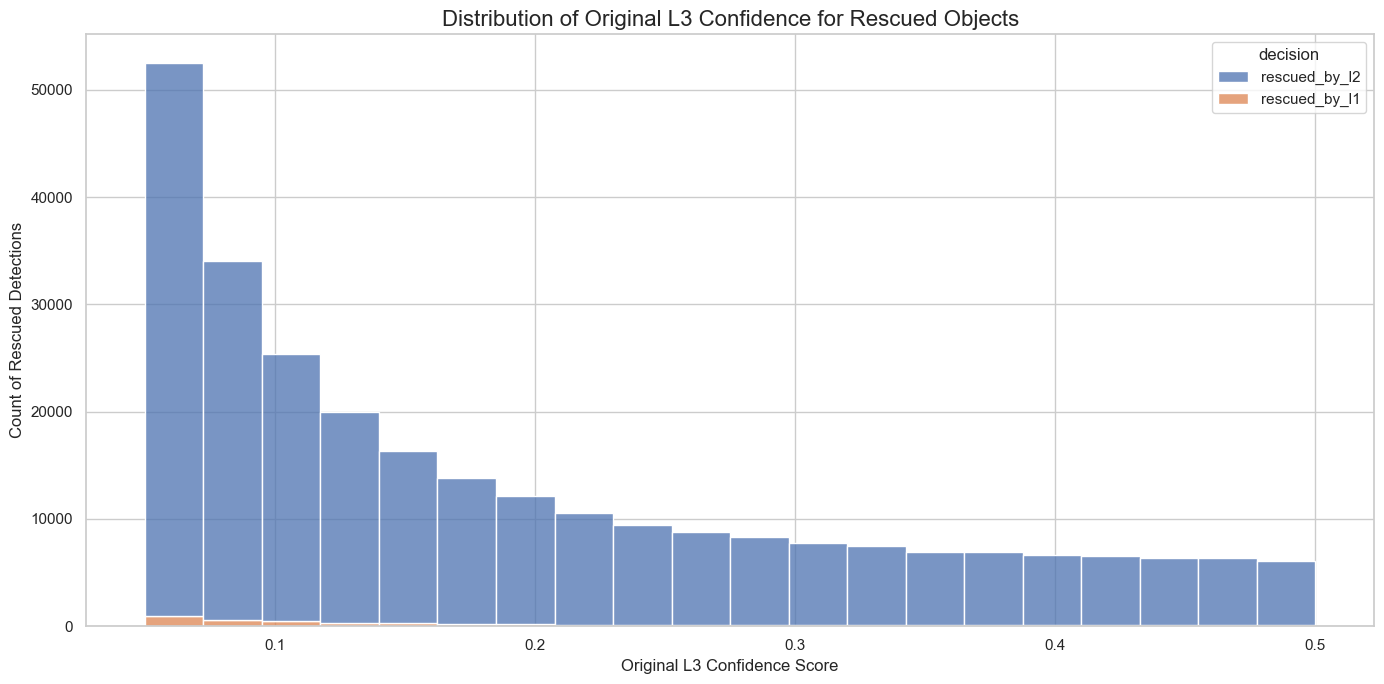

2025-09-05 23:48:49 [INFO] - Waterfall logic performance saved to mot_evaluation_results_train\metrics\waterfall_logic_performance.csv



                                   Hierarchical Model: Full Waterfall Logic Performance
          Sequence  Correct Rescues (TP)  Incorrect Rescues (FP)  Total Rescued Rescue Precision (%)  Correct Rejections (TN)  Missed Rescues (FN)  Total Dismissed Rejection Precision (%)
uav0000009_03358_v                2618.0                  2937.0         5555.0                47.13                   2072.0                629.0           2701.0                   76.71
uav0000013_00000_v                  34.0                   110.0          144.0                23.61                   2981.0               1179.0           4160.0                   71.66
uav0000013_01073_v                   9.0                    56.0           65.0                13.85                    440.0                 51.0            491.0                   89.61
uav0000013_01392_v                  69.0                   434.0          503.0                13.72                    797.0                124.0            9

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set_theme(style="whitegrid")

# 1. Generate the Distribution of Rescued Objects Plot
rescue_df_hist = pd.DataFrame(rescue_log_all)

plt.figure(figsize=(14, 7))
if not rescue_df_hist.empty:
    sns.histplot(
        data=rescue_df_hist,
        x='l3_conf',
        hue='decision',
        multiple='stack',
        bins=20,
        binrange=(L3_CANDIDATE_THRESH, L3_CONFIRM_THRESH),
        palette={'rescued_by_l2': 'b', 'rescued_by_l1': 'C1'}
    )
plt.title('Distribution of Original L3 Confidence for Rescued Objects', fontsize=16)
plt.xlabel('Original L3 Confidence Score', fontsize=12)
plt.ylabel('Count of Rescued Detections', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Build the Rescue and Rejection Performance DataFrames
# A. Build Rescue DataFrame
rescue_data = []
for seq_name, stats in rescue_stats.items():
    correct = stats['correct_rescues']
    incorrect = stats['incorrect_rescues']
    total = correct + incorrect
    precision = (correct / total * 100) if total > 0 else 0
    rescue_data.append({
        'Sequence': seq_name,
        'Correct Rescues (TP)': correct,
        'Incorrect Rescues (FP)': incorrect,
        'Total Rescued': total,
        'Rescue Precision (%)': precision
    })
rescue_df = pd.DataFrame(rescue_data)

# B. Build Rejection DataFrame
rejection_data = []
for seq_name, stats in rejection_stats.items():
    correct = stats['correct_rejections']
    missed = stats['missed_rescues']
    total = correct + missed
    precision = (correct / total * 100) if total > 0 else 0
    rejection_data.append({
        'Sequence': seq_name,
        'Correct Rejections (TN)': correct,
        'Missed Rescues (FN)': missed,
        'Total Dismissed': total,
        'Rejection Precision (%)': precision
    })
rejection_df = pd.DataFrame(rejection_data)

# 3. Merge into a Single Performance Table
if not rescue_df.empty or not rejection_df.empty:
    performance_df = pd.merge(rescue_df, rejection_df, on='Sequence', how='outer').fillna(0)

    # Convert float columns from merge back to integer where appropriate
    int_cols = [c for c in performance_df.columns if '(FP)' in c or '(TP)' in c or '(FN)' in c or '(TN)' in c or 'Total' in c]
    for col in int_cols:
        performance_df[col] = performance_df[col].astype(int)

    # Calculate and add OVERALL summary row
    overall = performance_df.sum(numeric_only=True)
    if overall['Total Rescued'] > 0: overall['Rescue Precision (%)'] = (overall['Correct Rescues (TP)'] / overall['Total Rescued'] * 100)
    if overall['Total Dismissed'] > 0: overall['Rejection Precision (%)'] = (overall['Correct Rejections (TN)'] / overall['Total Dismissed'] * 100)
    overall_df = pd.DataFrame(overall).T
    overall_df['Sequence'] = 'OVERALL'
    performance_df = pd.concat([performance_df, overall_df], ignore_index=True)

    # 4. Display the New, Comprehensive Metrics Table
    print("\n" + "="*120)
    print("                                   Hierarchical Model: Full Waterfall Logic Performance")
    print("="*120)
    
    # Format for better readability
    performance_df['Rescue Precision (%)'] = performance_df['Rescue Precision (%)'].map('{:.2f}'.format)
    performance_df['Rejection Precision (%)'] = performance_df['Rejection Precision (%)'].map('{:.2f}'.format)
    print(performance_df.to_string(index=False))
    print("="*120)
    print("\nMetric Definitions:")
    print("- Correct Rescues (TP):   A low-confidence object that was correctly rescued and matched a ground truth.")
    print("- Incorrect Rescues (FP): A low-confidence object that was incorrectly rescued (was background noise).")
    print("- Rescue Precision:       Of all objects the model rescued, what percentage were actually real objects?")
    print("- Correct Rejections (TN):  A low-confidence object that was background and correctly discarded.")
    print("- Missed Rescues (FN):      A low-confidence object that was a real object but was incorrectly discarded.")
    print("- Rejection Precision:    Of all objects the model discarded, what percentage were actually background noise?")
    
    # Save the analysis to a CSV file
    performance_df.to_csv(METRICS_OUTPUT_DIR / "waterfall_logic_performance.csv", index=False)
    logging.info(f"Waterfall logic performance saved to {METRICS_OUTPUT_DIR / 'waterfall_logic_performance.csv'}")

else:
    logging.info("No rescue or rejection data was logged.")